# Question 2: Applied ML

In [1]:
import numpy as np
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

## 2.1 Feature Preparation

To load the **20newsgroups** dataset, we use a built-in function in sklearn. **Warning:** If you do not already have this data set saved on your computer, it will automatically download it (Download size: ca 14MB)!

We then transform each of the 18'846 articles to a sparse vector of length 134'410. We compute this feature vector using the **TF-IDF** algorithm (TfidfVectorizer in sklearn).

In [2]:
newsgroups = fetch_20newsgroups(subset='all', 
                                shuffle=True,
                                remove=('headers', 'footers', 'quotes'))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(newsgroups.data)
y = newsgroups.target

In the assignment, it is asked to split the data into 80% training data, 10% validation data and 10% testing data.
We decided to not throw away 10% of the data for validation purposes and instead use crossvalidation with 90% of the total data and leave 10% for the test data.

During training with **crossvalidation**, we train the classifier multiple (k-fold) times on a different subset of the data and then test the results on the validation data subset that we shift in each iteration. In the end, we average the results from all iterations and the classifier has been trained and tested on the whole training set. A more detailed explanation of crossvalidation can be found in the lecture notes.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## 2.2 Training a Random Forest

The 20 news groups will be learned using a random forest classifier from sklearn.

In [4]:
rf = RandomForestClassifier()

### Finding best hyper parameters using grid search

To find the best hyperparameters, we conduct a simple **grid search** over the number of random trees (*n_estimators*) and the maximum depth of the trees (*max_depth*). We decided to stop with *max_depth* 50, since the running times start getting too high.

**Warning**: The gridsearch over 100 combinations of those two parameters takes a very long time! (Around 2 hours on a MacBook Pro)

In [5]:
param_grid = {
    "n_estimators": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "max_depth":    [ 5, 10, 15, 20, 25, 30, 35, 40, 45,  50]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)
rf_grid.fit(X_train, y_train)
print('Best hyper parameters:', rf_grid.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 119.8min finished


Best hyper parameters: {'max_depth': 50, 'n_estimators': 90}


### Plotting the grid search results

To evaluate how well the brute forced hyper parameters of the grid search are doing, we plot them in a grid and display their crossvalidation test accuracies:

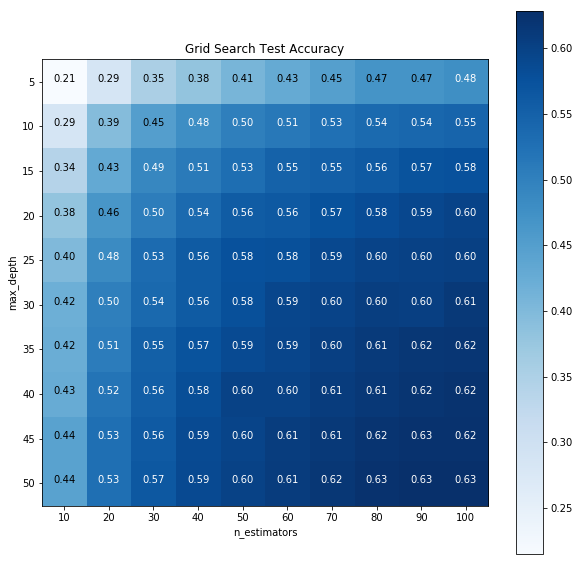

In [7]:
# Extract results from grid search
test_scores = rf_grid.cv_results_['mean_test_score']
test_scores = test_scores.reshape((len(param_grid['max_depth']), len(param_grid['n_estimators'])))
max_depth_idx = rf_grid.cv_results_['param_max_depth']
n_estimators_idx = rf_grid.cv_results_['param_n_estimators']

# Setting up grid plot
plt.figure(figsize=(10,10))
plt.imshow(test_scores, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Grid Search Test Accuracy')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.yticks(np.arange(len(param_grid['max_depth'])), param_grid['max_depth'])

fmt = '.2f'
thresh = test_scores.max() * 3 / 4.

# Adding test error numbers to plot
for i, j in itertools.product(range(test_scores.shape[0]), range(test_scores.shape[1])):
    plt.text(j, i, format(test_scores[i,j], fmt),
            horizontalalignment="center",
            color="white" if test_scores[i,j] > thresh else "black")

plt.ylabel('max_depth')
plt.xlabel('n_estimators')

In this plot, we clearly see that the model continues improving the higher each of the two parameters get. However, for the max_depth, we start getting diminishing returns for the accuracy at around depth 25. Similarily for the number of estimators, we stop getting much better accuracies after around 50 estimators.

From the grid search, we can directly extract the trained best model:

In [8]:
best_rf = rf_grid.best_estimator_

To assess if our model is good, we calculate various metrics using the test data that the algorithm has never seen. We propose the following metrics:

- Accuracy: The fraction of correctly labeled articles
- Precision: The fraction of positive predictions that are actually positive
- Recall: The fraction of positive examples that were recognized as positive
- F1: Harmonic mean of precision and recall

In [9]:
y_pred = cross_val_predict(best_rf, X_test, y_test, cv=5)
print('Evaluating quality of model with best parameters:\n')
print('Accuracy:\t', accuracy_score(y_test, y_pred))
print('Precision:\t', precision_score(y_test, y_pred, average='weighted'))
print('Recall:\t\t', recall_score(y_test, y_pred, average='weighted'))
print('F1:\t\t', f1_score(y_test, y_pred, average='weighted'))

Evaluating quality of model with best parameters:

Accuracy:	 0.505570291777
Precision:	 0.529460855265
Recall:		 0.505570291777
F1:		 0.497894526916


### Plotting the confusion matrix

In addition to the metrics above, another useful way to visually assess the quality of our predictions is a confusion matrix. In it, we plot a 2-dimensional histogram of the true labels of the test data against its the predictions from our model.

In [10]:
cm = confusion_matrix(y_test, y_pred)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


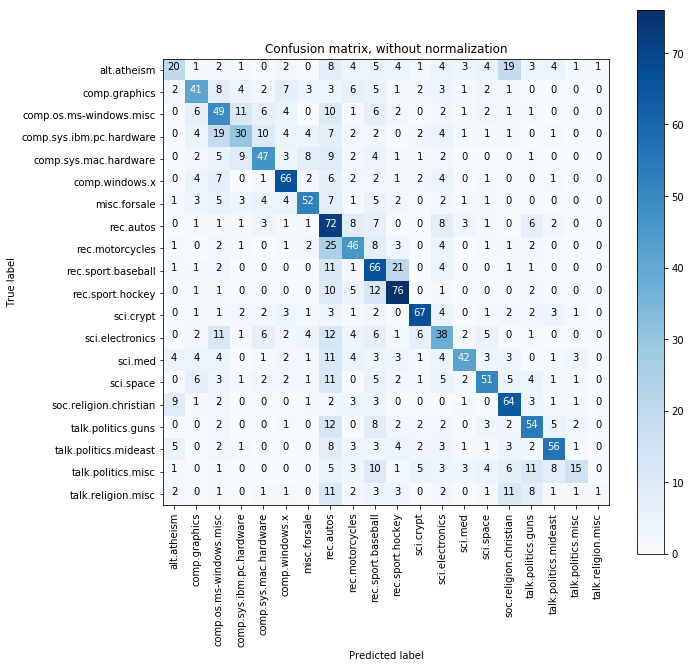

In [12]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=newsgroups.target_names,
                      title='Confusion matrix, without normalization')

We observe that most labels were correctly assigned, since the majority of entries in the confusion matrix lay on the diagonal. Many articles of all kinds of newsgroups were wrongly assigned to the category "rec:autos". Also, articles of the category "talk.religion.misc" had troubles being assigned to the true labels.

### Most important features

From the random forest with the best parameters, we extract the feature importances vector, where every element is the respective importance for the classification of each word. We then sort the words by the most important ones and display the first 100.

In [13]:
best_features_vec = best_rf.feature_importances_

feature_names = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(best_features_vec).flatten()[::-1]

n = 100
top_n = feature_names[tfidf_sorting][:n]
top_n

array(['game', 'bike', 'car', 'apple', 'windows', 'god', 'gun', 'shipping',
       'clipper', 'space', 'israel', 'encryption', 'team', 'dod', 'that',
       'israeli', 'hockey', 'offer', 'christ', 'jesus', 'key', 'of', 'mac',
       'graphics', 'the', 'arab', 'chip', 'nasa', 'church', 'to', 'guns',
       'government', 'he', 'his', 'people', 'nsa', 'motif', 'ride', 'is',
       'fbi', 'christian', 'keys', 'in', 'window', 'controller', 'bible',
       'riding', 'file', 'not', 'condition', 'be', 'my', 'games', 'and',
       'christianity', 'sale', 'season', 'dos', 'escrow', 'cars', 'who',
       'for', 'server', 'it', 'card', 'jews', 'nhl', 'ide', 'with', 'this',
       'doctor', 'baseball', 'have', 'can', 'are', 'on', 'they', 'you',
       'sell', 'thanks', 'widget', 'x11r5', 'playoff', 'as', 'asking',
       'bios', 'centris', 'was', 'by', 'but', 'league', 'scsi', 'if',
       'leafs', 'weapons', 'arabs', 'crypto', 'their', 'were', 'faith'],
      dtype='<U81')

Printing the 100 most important features from the random forrest, we see some obvious and less intuitive results. Many words like "game", "bike", "car", "apple" and "windows" are very specific to a certain news category, so it makes sense that they are important for the random forest in deciding to which category an article belongs.

Other words like "that", "of", "the", "to" can be assumed to be common words in every kind of category, so it is slightly strange that they have such a strong classification power.